In [17]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from spectra_dataset import get_dataloader, df_concat, spectra_Dataset
from tools import train_model, eval_model, eval_test_plotter, error_chi_squared

In [18]:
# loading data
wavelength_range = "ir"

df_cond = pd.read_csv("./data/interpolated_spectra.csv") # 10000 x 20
df_interpol = pd.read_csv("./data/spectra.csv") # 10000 x 223 

# focus only on the ir range (128 points) or the entire spectrum (243 points)
if wavelength_range == "ir":
    df_interpol_ir = df_interpol.iloc[:,66:66+108] # 10000 x 108 (66:66+108 yields points in 5-35 mu meter range)
    df_tot, cond_mask = df_concat(df_cond = df_cond, df_imp = df_interpol_ir) # 10000 x 128, 10000 x 128
    fluxes_np = df_tot.values
elif wavelength_range == "all":
    df_tot, cond_mask = df_concat(df_cond = df_cond, df_imp = df_interpol) # 10000 x 243, 10000 x 243
    fluxes_np = df_tot.values

sorted_wavelengths = df_tot.columns.values.astype(float)

fluxes_np.shape, sorted_wavelengths.shape, cond_mask.shape

((10000, 125), (125,), (10000, 125))

In [19]:
## Training
model, valid_loader = train_model(fluxes_np, cond_mask)

100%|██████████| 900/900 [00:06<00:00, 138.08it/s, valid_avg_epoch_loss=0.0609, epoch=4]


 best loss is updated to  0.06088614195649926 at 4


In [20]:
batch = next(iter(valid_loader))
batch["observed_data"].shape

torch.Size([1, 1, 125])

In [21]:
## Imputation 
# Samples has shape N x K x L; N=900 validation spectra, K = 1 feature, L = 128 or 243 time series length
# Compare samples to observed data; n.t. imputation does not happen at conditional points

eval_output = eval_model(model, valid_loader, num_samp = 5)

{'observed_data': tensor([[[-2.8694, -2.7516, -2.5617, -2.4036, -1.8727, -1.4600, -1.4165,
          -1.4145, -1.3392, -1.2495, -1.1651, -1.1460, -1.0859, -1.0279,
          -0.9921, -0.9622, -0.9146, -0.8934, -0.8820, -0.8661, -0.8158,
          -0.7881, -0.7853, -0.7436, -0.7877, -0.7830, -0.7736, -0.8209,
          -0.8375, -0.8202, -0.8134, -0.7582, -0.7532, -0.7153, -0.6759,
          -0.6283, -0.6342, -0.6405, -0.6357, -0.6252, -0.5703, -0.4657,
          -0.3378, -0.2347, -0.1797, -0.1158, -0.0512, -0.0442,  0.0052,
           0.0671,  0.1424,  0.2979,  0.3843,  0.3358,  0.2924,  0.2881,
           0.3439,  0.3928,  0.4775,  0.4479,  0.4625,  0.4952,  0.5682,
           0.5811,  0.5534,  0.4786,  0.3716,  0.3203,  0.1077,  0.0646,
           0.1047,  0.1437,  0.0904,  0.0368,  0.0241,  0.0318,  0.0470,
           0.0672,  0.0956,  0.1189,  0.1484,  0.2318,  0.2901,  0.3494,
           0.3179,  0.2881,  0.2808,  0.2912,  0.3112,  0.3363,  0.3603,
           0.3783,  0.3936,  0.43

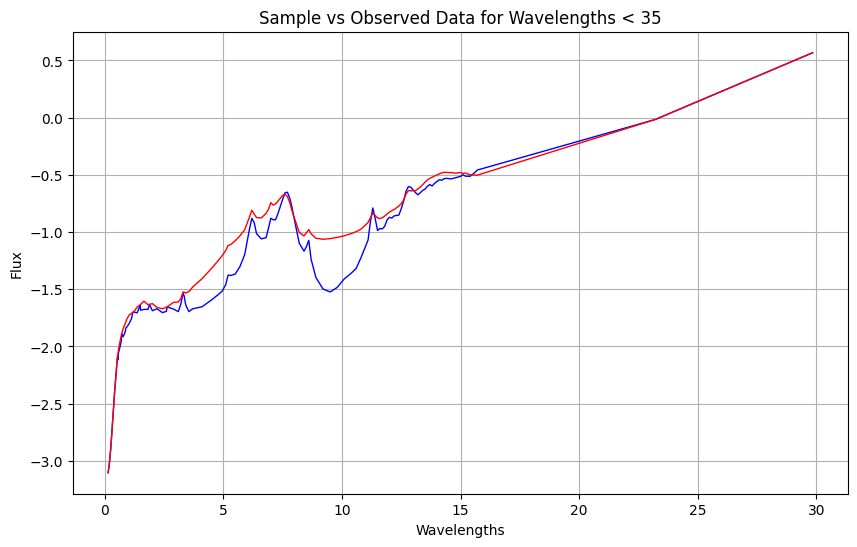

In [22]:
                                                    ## Plotting
# Change index to view a different spectrum
# Vary i,j to constrain the length of the time series

index = 0

valid_dataset = spectra_Dataset(fluxes_np, cond_mask, eval_length=cond_mask.shape[-1], target_dim=1, mode="valid")
eval_test_plotter(eval_output, cond_mask, 10**sorted_wavelengths, valid_dataset, index=index, i=0, j=1)

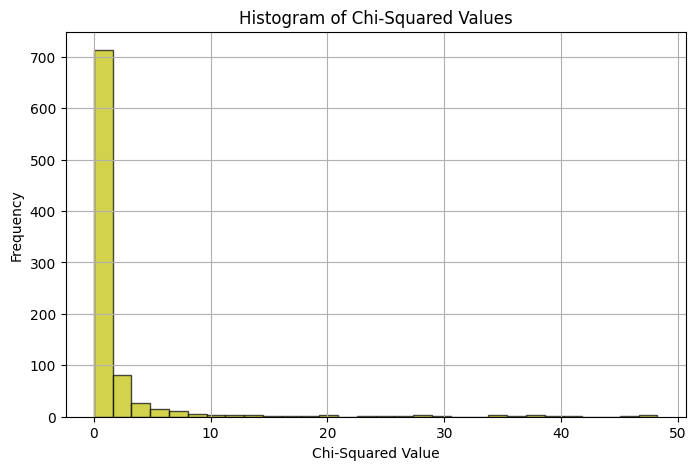

91.44444444444444

In [30]:
# calculating chi_squared; same metric as in the paper (chi_over_5 = % of chi_squares under 5)

chi_squared, chi_under_5 = error_chi_squared(eval_output, cond_mask, valid_dataset, i = 0, j = 35)
chi_under_5

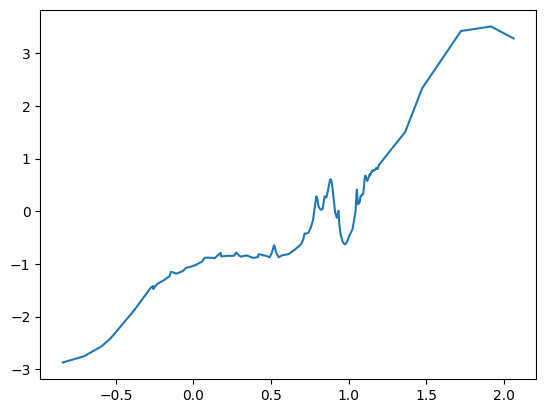

In [24]:
plt.plot(sorted_wavelengths, eval_output[0][0][0][:])

In [25]:
import pandas as pd
import numpy as np
import torch

# Load photometry data
df_photo = pd.read_csv('./data/interpolated_spectra.csv').T
df_photo.columns = range(len(df_photo.columns))
data_ph = df_photo.values.astype(np.float64)
data_scaled_ph = data_ph / np.max(data_ph)  # Normalize data
fluxes_ph = data_ph[:, :]  # Shape [10000, 17]

# Load spectra data
df_spectra = pd.read_csv('./data/spectra.csv').T
df_spectra.columns = range(len(df_spectra.columns))
data_sp = df_spectra.values.astype(np.float64)
data_scaled_sp = data_sp / np.max(data_sp)  # Normalize data
fluxes_sp = data_sp[:, :]  # Shape [10000, 203]

# Convert to PyTorch tensors for model input
test_photometry_data = torch.tensor(data_scaled_ph.T, dtype=torch.float32).unsqueeze(2)  # Shape [17, 10000, 1]
test_spectra_data = torch.tensor(data_scaled_sp.T, dtype=torch.float32)  # Shape [203, 10000]

# Load wavelengths for photometry
df_wavelengths = pd.read_csv('./data/interpolated_spectra.csv').T
df_wavelengths.reset_index(inplace=True)
df_wavelengths.columns = range(len(df_wavelengths.columns))
df_wavelengths = df_wavelengths.values.astype(np.float64)
df_wavelengths_scaled = df_wavelengths / np.max(df_wavelengths)
data_wavelengths_photo = df_wavelengths[:, 0]  # Shape: [17]

# Load wavelengths for spectra
df_wavelengths_spectra = pd.read_csv('./data/spectra.csv').T
df_wavelengths_spectra.reset_index(inplace=True)
df_wavelengths_spectra.columns = range(len(df_wavelengths_spectra.columns))
df_wavelengths_spectra = df_wavelengths_spectra.values.astype(np.float64)
df_wavelengths_scaled_spectra = df_wavelengths_spectra / np.max(df_wavelengths_spectra)
data_wavelengths_spectra = df_wavelengths_spectra[:, 0]  # Shape: [203]

# Print shapes for verification
print("Photometry wavelengths shape:", data_wavelengths_photo.shape)
print("Spectra wavelengths shape:", data_wavelengths_spectra.shape)


Photometry wavelengths shape: (17,)
Spectra wavelengths shape: (206,)


In [26]:
from torch.utils.data import Dataset, DataLoader

class TestDataset(Dataset):
    def __init__(self, data, cond_mask=None):
        self.data = data
        self.cond_mask = cond_mask if cond_mask is not None else torch.ones_like(data)

    def __getitem__(self, index):
        # Prepare batch structure expected by the model
        return {
            "observed_data": self.data[:, index],  # Data for the model
            "observed_mask": torch.ones_like(self.data[:, index]),  # Assume all data is observed
            "cond_mask": self.cond_mask[:, index],  # Conditional mask
            "gt_mask": self.cond_mask[:, index],  # Ground truth mask
            "timepoints": torch.arange(self.data.size(0), dtype=torch.float32)  # Dummy timepoints
        }

    def __len__(self):
        return self.data.size(1)  # Number of samples


In [27]:
# Create conditional masks for photometry and spectra
cond_mask_photometry = torch.ones_like(test_photometry_data.T)  # Full mask
cond_mask_spectra = torch.ones_like(test_spectra_data.T)  # Full mask

# Create datasets
test_dataset_photometry = TestDataset(test_photometry_data.T, cond_mask_photometry)
test_dataset_spectra = TestDataset(test_spectra_data.T, cond_mask_spectra)

# Create DataLoaders
batch_size = 32  # Adjust based on system memory
test_loader_photometry = DataLoader(test_dataset_photometry, batch_size=batch_size, shuffle=False)
test_loader_spectra = DataLoader(test_dataset_spectra, batch_size=batch_size, shuffle=False)


In [28]:
val = next(iter(test_loader_photometry))
val["timepoints"].shape

torch.Size([17, 1])

In [29]:
from tools import eval_model

# Evaluate on photometry data
eval_output_photometry = eval_model(model, test_loader_photometry)

# Evaluate on spectra data
eval_output_spectra = eval_model(model, test_loader_spectra)

print("Evaluation on photometry data complete.")
print("Evaluation on spectra data complete.")


{'observed_data': tensor([[[ 0.1587,  0.0297, -0.6581,  ..., -0.4583, -0.0602,  0.0907]],

        [[ 0.1622,  0.0449, -0.5916,  ..., -0.4462, -0.0505,  0.0897]],

        [[ 0.1733,  0.0726, -0.5486,  ..., -0.4339, -0.0423,  0.1002]],

        ...,

        [[ 0.5138,  0.4389,  0.3066,  ...,  0.5884,  0.2248,  0.4632]],

        [[ 0.5257,  0.4620,  0.3062,  ...,  0.5936,  0.1731,  0.4897]],

        [[ 0.5119,  0.4554,  0.2776,  ...,  0.5664,  0.1149,  0.4934]]]), 'observed_mask': tensor([[[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]]]), 'cond_mask': tensor([[[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]]

RuntimeError: Sizes of tensors must match except in dimension 3. Expected size 1 but got size 10000 for tensor number 1 in the list.

In [ ]:
from tools import eval_model

# Load your trained model (ensure it’s already trained)
# Assuming `model` is an instance of your trained model
# model = torch.load("path_to_trained_model.pth")
model.eval()

# Evaluate the model on the photometry data
eval_output_photometry = eval_model(model, test_photometry_data)

# Evaluate the model on the spectra data
eval_output_spectra = eval_model(model, test_spectra_data)

print("Evaluation on photometry data complete.")
print("Evaluation on spectra data complete.")


IndexError: too many indices for tensor of dimension 2

In [ ]:
from tools import eval_test_plotter

# Plot photometry results
sorted_wavelengths_photo = data_wavelengths_photo  # Use photometry wavelengths
eval_test_plotter(
    eval_output_photometry,
    cond_mask=np.ones_like(data_scaled_ph.T),  # Assuming full observed mask
    sorted_wavelengths=sorted_wavelengths_photo,
    valid_dataset=None,  # Set if using valid dataset
    index=0
)

# Plot spectra results
sorted_wavelengths_spectra = data_wavelengths_spectra  # Use spectra wavelengths
eval_test_plotter(
    eval_output_spectra,
    cond_mask=np.ones_like(data_scaled_sp.T),  # Assuming full observed mask
    sorted_wavelengths=sorted_wavelengths_spectra,
    valid_dataset=None,  # Set if using valid dataset
    index=0
)


torch.Size([1, 1, 223])


In [ ]:
from tools import error_chi_squared

# Calculate chi-squared and error percentage for photometry data
chi_squared_photo, chi_under_5_photo = error_chi_squared(eval_output_photometry, cond_mask=np.ones_like(data_scaled_ph.T))
print(f"Photometry Chi-squared: {chi_squared_photo}")
print(f"Percentage of chi-squared under 5 (Photometry): {chi_under_5_photo}%")

# Calculate chi-squared and error percentage for spectra data
chi_squared_spectra, chi_under_5_spectra = error_chi_squared(eval_output_spectra, cond_mask=np.ones_like(data_scaled_sp.T))
print(f"Spectra Chi-squared: {chi_squared_spectra}")
print(f"Percentage of chi-squared under 5 (Spectra): {chi_under_5_spectra}%")
